# Product Level LGBM

Comparing to handle the problem from store level and then breaking down into products by monthly sale ratios, this notebook directly build a model to do time series forecast product by product.

Steps:

1. Load raw data
2. Reduce memory usage
3. Feature engineering
4. Modelling and prediction
5. Save the results

A lot of codes here are learned from a public notebook on Kaggle: https://www.kaggle.com/anshuls235/m5-forecasting-eda-fe-modelling/notebook. Thank you Anshul Sharma!

In [55]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')
from lightgbm import LGBMRegressor
import joblib
from sklearn.metrics import mean_squared_error as mse
import operator

## Load raw data

In [2]:
sales = pd.read_csv('sales_train_evaluation.csv')
calendar = pd.read_csv('calendar.csv')
prices = pd.read_csv('sell_prices.csv')

In [3]:
#Add zero sales for the remaining days 1942-1969
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)

## Reduce memory usage

In [4]:
print(f'''
Memory Usage 
sales_train_evaluation: {round(sum(sales.memory_usage())/2**27,2)} GB
calendar: {round(sum(calendar.memory_usage())/2**17)} MB
sell_prices: {round(sum(prices.memory_usage())/2**27,2)} GB
Total: {round(sum(sales.memory_usage())/2**27+sum(calendar.memory_usage())/2**27+sum(prices.memory_usage())/2**27,2)} GB
''')


Memory Usage 
sales_train_evaluation: 3.55 GB
calendar: 2 MB
sell_prices: 1.63 GB
Total: 5.18 GB



### Numerical Columns

Depending on the environment, pandas automatically creates int32, int64, float32 or float64 columns for numeric ones. If you know the min or max value of a column, you can use a subtype which is less memory consuming. You can also use an unsigned subtype if there is no negative value.

Here are the different subtypes you can use:

- `int8 / uint8` : consumes 1 byte of memory, range between -128/127 or 0/255
- `bool` : consumes 1 byte, true or false
- `float16 / int16 / uint16`: consumes 2 bytes of memory, range between -32768 and 32767 or 0/65535
- `float32 / int32 / uint32` : consumes 4 bytes of memory, range between -2147483648 and 2147483647
- `float64 / int64 / uint64`: consumes 8 bytes of memory

### Categorical Columns

Pandas stores categorical columns as objects. One of the reason this storage is not optimal is that it creates a list of pointers to the memory address of each value of your column. For columns with low cardinality (the amount of unique values is lower than 50% of the count of these values), this can be optimized by forcing pandas to use a virtual mapping table where all unique values are mapped via an integer instead of a pointer. This is done using the category datatype.

In [5]:
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

In [6]:
sales = downcast(sales)
print("sales_e finished")
prices = downcast(prices)
print("prices finished")
calendar = downcast(calendar)
print("calendar finished")

sales_e finished
prices finished
calendar finished


In [7]:
print(f'''
Memory Usage 
sales_train_evaluation: {round(sum(sales.memory_usage())/2**27,2)} GB
calendar: {round(sum(calendar.memory_usage())/2**17)} MB
sell_prices: {round(sum(prices.memory_usage())/2**27,2)} GB
Total: {round(sum(sales.memory_usage())/2**27+sum(calendar.memory_usage())/2**27+sum(prices.memory_usage())/2**27,2)} GB
''')


Memory Usage 
sales_train_evaluation: 0.76 GB
calendar: 1 MB
sell_prices: 0.36 GB
Total: 1.12 GB



We reduce 78% of the memory usage comparing to the raw data!

## Feature engineering

In [14]:
# merge the tables
df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], \
             var_name='d', value_name='sold').dropna()
df = pd.merge(df, calendar, on='d', how='left')
df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left') 

Time Series data must be re-framed as a supervised learning dataset before we can start using machine learning algorithms.

In [15]:
def feature_engineer(df):
    #Store the categories along with their codes
    d_id = dict(zip(df.id.cat.codes, df.id))
    d_item_id = dict(zip(df.item_id.cat.codes, df.item_id))
    d_dept_id = dict(zip(df.dept_id.cat.codes, df.dept_id))
    d_cat_id = dict(zip(df.cat_id.cat.codes, df.cat_id))
    d_store_id = dict(zip(df.store_id.cat.codes, df.store_id))
    d_state_id = dict(zip(df.state_id.cat.codes, df.state_id))
    print(1)
    

    #Label Encode categorical features
    df.d = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,type in enumerate(types):
        if type.name == 'category':
            df[cols[i]] = df[cols[i]].cat.codes

    #Remove date as its features are already present
    df.drop('date',axis=1,inplace=True)
    print(2)
    
    #Introduce lags
    lags = [1,2,3,4,5,6,7,14,28,30,60]
    for lag in lags:
        df['sold_lag_'+str(lag)] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],\
                                          as_index=False)['sold'].shift(lag).astype(np.float16)
    print(3)
    #Mean Encoding
    df['iteam_sold_avg'] = df.groupby('item_id')['sold'].transform('mean').astype(np.float16)
    df['state_sold_avg'] = df.groupby('state_id')['sold'].transform('mean').astype(np.float16)
    df['store_sold_avg'] = df.groupby('store_id')['sold'].transform('mean').astype(np.float16)
    df['cat_sold_avg'] = df.groupby('cat_id')['sold'].transform('mean').astype(np.float16)
    df['dept_sold_avg'] = df.groupby('dept_id')['sold'].transform('mean').astype(np.float16)
    df['cat_dept_sold_avg'] = df.groupby(['cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
    df['store_item_sold_avg'] = df.groupby(['store_id','item_id'])['sold'].transform('mean').astype(np.float16)
    df['cat_item_sold_avg'] = df.groupby(['cat_id','item_id'])['sold'].transform('mean').astype(np.float16)
    df['dept_item_sold_avg'] = df.groupby(['dept_id','item_id'])['sold'].transform('mean').astype(np.float16)
    df['state_store_sold_avg'] = df.groupby(['state_id','store_id'])['sold'].transform('mean').astype(np.float16)
    df['state_store_cat_sold_avg'] = df.groupby(['state_id','store_id','cat_id'])['sold'].transform('mean').astype(np.float16)
    df['store_cat_dept_sold_avg'] = df.groupby(['store_id','cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
    print(4)
    
    #Rolling Window Statistics
    df['rolling_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']\
                                        )['sold'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)
    df['rolling_sold_std'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']\
                                        )['sold'].transform(lambda x: x.rolling(window=7).std()).astype(np.float16)
    df['rolling_price_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']\
                                        )['sell_price'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)
    df['rolling_price_std'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']\
                                        )['sell_price'].transform(lambda x: x.rolling(window=7).std()).astype(np.float16)
    print(5)
    
    #Trends
    df['daily_avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d'])['sold'].transform('mean').astype(np.float16)
    df['avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform('mean').astype(np.float16)
    df['selling_trend'] = (df['daily_avg_sold'] - df['avg_sold']).astype(np.float16)
    df.drop(['daily_avg_sold','avg_sold'],axis=1,inplace=True)
    
    df = df[df['d']>60]
    
    return df

In [16]:
df = feature_engineer(df)
df.info()

1
2
3
4
5
<class 'pandas.core.frame.DataFrame'>
Int64Index: 58205410 entries, 1829400 to 60034809
Data columns (total 47 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   id                        int16  
 1   item_id                   int16  
 2   dept_id                   int8   
 3   cat_id                    int8   
 4   store_id                  int8   
 5   state_id                  int8   
 6   d                         int16  
 7   sold                      int16  
 8   wm_yr_wk                  int16  
 9   weekday                   int8   
 10  wday                      int8   
 11  month                     int8   
 12  year                      int16  
 13  event_name_1              int8   
 14  event_type_1              int8   
 15  event_name_2              int8   
 16  event_type_2              int8   
 17  snap_CA                   int8   
 18  snap_TX                   int8   
 19  snap_WI                   int8   
 20  sell_p

In [36]:
# This is used for recurrently revising features and doing predictions day by day in the next section.
def fe_short(df):
    lags = [1,2,3,4,5,6,7,14,28,30,60]
    for lag in lags:
        df['sold_lag_'+str(lag)] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],\
                                          as_index=False)['sold'].shift(lag).astype(np.float16)
    
    #Rolling Window Statistics
    df['rolling_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']\
                                        )['sold'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)
    df['rolling_sold_std'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']\
                                        )['sold'].transform(lambda x: x.rolling(window=7).std()).astype(np.float16)
    
    #Trends
    df['daily_avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d'])['sold'].transform('mean').astype(np.float16)
    df['avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform('mean').astype(np.float16)
    df['selling_trend'] = (df['daily_avg_sold'] - df['avg_sold']).astype(np.float16)
    df.drop(['daily_avg_sold','avg_sold'],axis=1,inplace=True)
    
    return df

## Modelling and prediction

In [24]:
X_train, y_train = df[df['d']<1942].drop('sold',axis=1), df[df['d']<1942]['sold']
X_test = df[df['d']>=1942].drop('sold',axis=1)

X_valid, y_valid = df[(df['d']>=1914) & (df['d']<1942)].drop('sold',axis=1), df[(df['d']>=1914) & (df['d']<1942)]['sold']

y_before = df[df['d']>=1942]['sold']

model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.3,
    subsample=0.8,
    colsample_bytree=0.8,
    max_depth=8,
    num_leaves=50,
    min_child_weight=300
)
model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
         eval_metric='rmse', verbose=20, early_stopping_rounds=20)
print("model finished")
y_after = model.predict(X_test)
df['sold'][X_test.index] = model.predict(X_test)
error = mse(y_after,y_before)
print("MSE of before and after:",error)
df = fe_short(df)
print("fe finished")

Training until validation scores don't improve for 20 rounds
[20]	training's rmse: 0.73311	training's l2: 0.53745	valid_1's rmse: 0.547231	valid_1's l2: 0.299462
[40]	training's rmse: 0.634946	training's l2: 0.403156	valid_1's rmse: 0.466775	valid_1's l2: 0.217878
[60]	training's rmse: 0.581722	training's l2: 0.3384	valid_1's rmse: 0.428388	valid_1's l2: 0.183516
[80]	training's rmse: 0.54106	training's l2: 0.292746	valid_1's rmse: 0.399667	valid_1's l2: 0.159734
[100]	training's rmse: 0.514074	training's l2: 0.264272	valid_1's rmse: 0.380828	valid_1's l2: 0.14503
[120]	training's rmse: 0.49412	training's l2: 0.244155	valid_1's rmse: 0.366918	valid_1's l2: 0.134629
[140]	training's rmse: 0.477712	training's l2: 0.228209	valid_1's rmse: 0.354234	valid_1's l2: 0.125481
[160]	training's rmse: 0.462506	training's l2: 0.213912	valid_1's rmse: 0.344486	valid_1's l2: 0.11867
[180]	training's rmse: 0.450223	training's l2: 0.202701	valid_1's rmse: 0.334412	valid_1's l2: 0.111831
[200]	training'

In [27]:
df['sold'][X_test.index]=np.nan

In [28]:
df = fe_short(df)

3
4
5


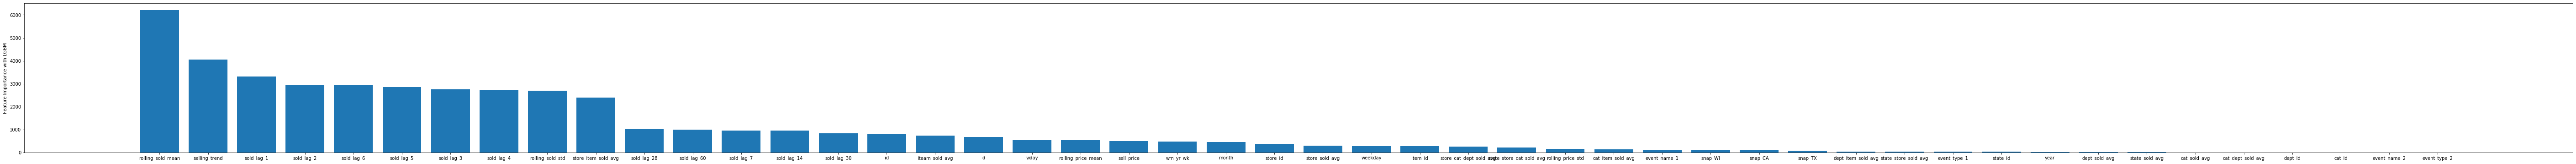

In [31]:
# feature importance
variable_importance = []
for i in range(len(X_test.columns)):
    variable_importance.append((X_test.columns[i],model.feature_importances_[i]))
variable_importance.sort(key = operator.itemgetter(1), reverse=True)

selected_variable = [x[0] for x in variable_importance]
selected_importance = [x[1] for x in variable_importance]
plt.figure(figsize=(100,6))
plt.bar(selected_variable,selected_importance)
plt.ylabel("Feature Importance with LGBM")
plt.show()

In [45]:
for i in range(1942,1970):
    print(i)
    index_list = X_test[X_test.d == i].index
    l = model.predict(X_test.loc[index_list,:])
    l[l<0] = 0
    df['sold'][index_list] = l
    df = fe_short(df)
    X_test = df[df['d']>=1942].drop('sold',axis=1)

1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969


## Save the results

In [51]:
validation = sales[['id']+['d_' + str(i) for i in range(1914,1942)]]
validation['id']=pd.read_csv('sales_train_validation.csv').id
validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]

evaluation = df[df['d']>=1942][['id','d','sold']]
evaluation = pd.pivot(evaluation, index='id', columns='d', values='sold').reset_index()
evaluation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
evaluation.id = validation.id.apply(lambda x: x[:-10]+'evaluation')

#Prepare the submission
submit = pd.concat([validation,evaluation]).reset_index(drop=True)
submit.to_csv('submission.csv',index=False)

In [54]:
# save the data and model
# the <1914 part of the df is untouched
df.to_pickle('data.pkl')
joblib.dump(model, 'modelLGBM.pkl')
gc.collect();